# Проект телеком

[Введение](#beginning)

1. [Подготовка данных](#preparation)


2. [Кодирование признаков](#coding)


3. [Анализ данных](#analysis)


4. [Разделение данных на выборки для обучения](#split)


5. [Борьба с дисбалансом в выборке](#disbalance)


    
6. [Моделирование](#modelling)

    6.1. [CatBoost](#cat)
    
    6.2. [Модель Catboost после удаления неважных признаков](#cat_short)
    
    6.3. [LogisticRegression_weighted](#logistic)
    
    6.4. [Модель LGBMClassifier (без малозначимых признаков)](#lgbm)
    
    6.5. [Catboost на уменьшенной выборке](#cat_down)
    
[Общий вывод](#summary) 

[Отчёт](#report) 

<a id="beginning"></a>
# Введение

В ходе данной работы будет построена модель для прогнозирования оттока клиентов для телекоммуникационной компании.

Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах, на основании которых и будет произведён анализ данных и построение модели.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
from scipy import stats as st
from math import factorial
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMClassifier
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
contract = pd.read_csv("/final_project/contract.csv")
internet = pd.read_csv("/internet.csv")
personal = pd.read_csv("/personal.csv")
phone = pd.read_csv("/phone.csv")

<a id="preparation"></a>
# 1. Подготовка данных 

In [3]:
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
438,5886-VLQVU,2017-03-01,No,Month-to-month,Yes,Bank transfer (automatic),89.850,3161.2
6354,3214-IYUUQ,2015-01-01,No,One year,No,Bank transfer (automatic),93.700,5860.7
2833,5993-JSUWV,2014-08-01,No,Two year,Yes,Bank transfer (automatic),61.150,4017.45
570,7293-LSCDV,2015-02-01,No,Two year,Yes,Credit card (automatic),19.250,1103.25
1148,7851-WZEKY,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,95.150,196.9


In [4]:
internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1890,8231-BSWXX,Fiber optic,No,Yes,No,No,No,No
5313,5681-LLOEI,Fiber optic,Yes,No,Yes,Yes,No,No
3793,3721-CNEYS,Fiber optic,No,No,No,No,No,No
3468,3716-LRGXK,Fiber optic,No,No,Yes,No,Yes,Yes
2313,5815-HGGHV,DSL,Yes,No,No,Yes,No,Yes


In [5]:
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
150,3780-YVMFA,Female,0,Yes,Yes
6320,8845-LWKGE,Female,0,Yes,Yes
5908,4786-UKSNZ,Male,0,No,No
3320,2195-VVRJF,Male,1,Yes,No
222,6469-MRVET,Male,0,Yes,Yes


In [6]:
phone.sample(5)

,customerID,MultipleLines
1832,7639-OPLNG,Yes
1516,4829-AUOAX,Yes
5262,1169-WCVAK,Yes
1792,2430-RRYUW,No
2831,0396-YCHWO,Yes


In [7]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


In [11]:
contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [12]:
contract.describe()

,MonthlyCharges
count,7043.000
mean,64.762
std,30.090
min,18.250
25%,35.500
50%,70.350
75%,89.850
max,118.750


In [13]:
contract['BeginDate'].value_counts()

2014-02-01    366
2019-10-01    237
2019-09-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

Склеим все таблицы в одну

In [14]:
data_merged = contract.merge(personal, how='outer', on = ['customerID'])

In [15]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 12 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 715.3+ KB


In [16]:
data_merged = data_merged.merge(internet, how='outer', on = ['customerID'])

In [17]:
data_merged = data_merged.merge(phone, how='outer', on = ['customerID'])

In [18]:
data_merged.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [19]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


Скорректируем типы данных в столбцах

In [20]:
data_merged['BeginDate'] = pd.to_datetime(data_merged['BeginDate'], format='%Y-%m-%d')

In [21]:
data_merged['InternetService'] = data_merged['InternetService'].fillna("non_user")
data_merged['OnlineSecurity'] = data_merged['OnlineSecurity'].fillna("non_user")
data_merged['OnlineBackup'] = data_merged['OnlineBackup'].fillna("non_user")
data_merged['DeviceProtection'] = data_merged['DeviceProtection'].fillna("non_user")
data_merged['TechSupport'] = data_merged['TechSupport'].fillna("non_user")
data_merged['StreamingTV'] = data_merged['StreamingTV'].fillna("non_user")
data_merged['StreamingMovies'] = data_merged['StreamingMovies'].fillna("non_user")
data_merged['MultipleLines'] = data_merged['MultipleLines'].fillna("non_user")

закодируем целевой признак: если человек ушёл - 1, остался - 0

In [22]:
data_merged['target'] = data_merged['EndDate'].apply(lambda x : 0 if x == "No" else 1)

In [23]:
data_merged['EndDate'] = data_merged['EndDate'].replace('No', "2020-02-01")

In [24]:
data_merged['EndDate'] = pd.to_datetime(data_merged['EndDate'], format='%Y-%m-%d')

In [25]:
data_merged["TotalCharges"] = np.where(data_merged["TotalCharges"]==' ', '0', data_merged["TotalCharges"])

In [26]:
data_merged['TotalCharges'] = data_merged['TotalCharges'].astype('float64')

In [27]:
data_merged['time_with_company'] = data_merged['EndDate'] - data_merged['BeginDate']

In [28]:
data_merged['time_with_company'] = data_merged['time_with_company'].dt.days

In [29]:
data_merged.sample(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,time_with_company
3827,6870-ECSHE,2019-12-01,2020-02-01,One year,No,Mailed check,20.450,34.800,Female,0,No,No,non_user,non_user,non_user,non_user,non_user,non_user,non_user,No,0,62
1920,4623-ZKHLY,2018-04-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),20.450,471.550,Male,0,Yes,No,non_user,non_user,non_user,non_user,non_user,non_user,non_user,No,0,671
6706,7878-RTCZG,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.900,19.900,Female,0,No,No,non_user,non_user,non_user,non_user,non_user,non_user,non_user,No,0,31
815,3196-NVXLZ,2018-01-01,2020-02-01,Month-to-month,Yes,Mailed check,84.600,2088.050,Female,0,No,No,Fiber optic,No,No,No,No,Yes,No,Yes,0,761
4015,8570-KLJYJ,2017-02-01,2020-02-01,One year,No,Mailed check,54.450,1893.500,Female,0,No,No,DSL,Yes,No,No,No,No,No,Yes,0,1095
3294,1086-LXKFY,2019-12-01,2020-01-01,Month-to-month,Yes,Mailed check,69.100,69.100,Female,0,Yes,Yes,Fiber optic,No,No,No,No,No,No,No,1,31
2046,2538-OIMXF,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,24.700,24.700,Female,0,No,Yes,DSL,No,No,No,No,No,No,non_user,0,31
1017,9361-YNQWJ,2014-10-01,2020-02-01,One year,Yes,Bank transfer (automatic),24.400,1601.200,Female,0,No,No,non_user,non_user,non_user,non_user,non_user,non_user,non_user,Yes,0,1949
3079,2141-RRYGO,2019-06-01,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),68.650,261.250,Female,0,No,No,DSL,No,Yes,No,No,Yes,Yes,No,1,122
4023,1686-STUHN,2016-08-01,2020-02-01,One year,No,Bank transfer (automatic),19.800,849.900,Male,0,No,No,non_user,non_user,non_user,non_user,non_user,non_user,non_user,No,0,1279


In [30]:
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID           7043 non-null object
BeginDate            7043 non-null datetime64[ns]
EndDate              7043 non-null datetime64[ns]
Type                 7043 non-null object
PaperlessBilling     7043 non-null object
PaymentMethod        7043 non-null object
MonthlyCharges       7043 non-null float64
TotalCharges         7043 non-null float64
gender               7043 non-null object
SeniorCitizen        7043 non-null int64
Partner              7043 non-null object
Dependents           7043 non-null object
InternetService      7043 non-null object
OnlineSecurity       7043 non-null object
OnlineBackup         7043 non-null object
DeviceProtection     7043 non-null object
TechSupport          7043 non-null object
StreamingTV          7043 non-null object
StreamingMovies      7043 non-null object
MultipleLines        7043 non-null object
target               7043 non-null i

In [31]:
data_merged.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,target,time_with_company
count,7043.000,7043.000,7043.000,7043.000,7043.000
mean,64.762,2279.734,0.162,0.265,985.996
std,30.090,2266.794,0.369,0.442,747.588
min,18.250,0.000,0.000,0.000,0.000
25%,35.500,398.550,0.000,0.000,273.000
50%,70.350,1394.550,0.000,0.000,883.000
75%,89.850,3786.600,0.000,1.000,1676.000
max,118.750,8684.800,1.000,1.000,2191.000


***Вывод***

Из данных были удалены пропуски, данные были приведены к нужным форматам, были созданы новые столбцы с целевым признаком (фактом ухода клиента) и сроком сотрудничества клиента с компанией.

<a id="coding"></a>
## 2. Кодирование признаков

Закодируем категориальные признаки методами get_dummies и OrdinalEncoder.

In [32]:
categorial_ohe = ['PaperlessBilling', 'gender', 'Dependents']
categorial_ord = ['Type', 'Partner', 'PaymentMethod', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [33]:
data_ohe = pd.get_dummies(data=data_merged, columns=categorial_ohe, drop_first=True)
data_ohe = data_ohe.reset_index()

In [34]:
encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data_ohe[categorial_ord]), columns = categorial_ord)
data_ordinal.reset_index()
display(data_ordinal.head())

,Type,Partner,PaymentMethod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0.000,1.000,2.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,2.000
1,1.000,0.000,3.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000
2,0.000,0.000,3.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
3,1.000,0.000,0.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,2.000
4,0.000,0.000,2.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [35]:
data_ohe[categorial_ord] = data_ordinal[categorial_ord]

In [36]:
del data_ohe['index']

In [37]:
data_ohe.head()

,customerID,BeginDate,EndDate,Type,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,time_with_company,PaperlessBilling_Yes,gender_Male,Dependents_Yes
0,7590-VHVEG,2020-01-01,2020-02-01,0.000,2.000,29.850,29.850,0,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,2.000,0,31,1,0,0
1,5575-GNVDE,2017-04-01,2020-02-01,1.000,3.000,56.950,1889.500,0,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0,1036,0,1,0
2,3668-QPYBK,2019-10-01,2019-12-01,0.000,3.000,53.850,108.150,0,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1,61,1,1,0
3,7795-CFOCW,2016-05-01,2020-02-01,1.000,0.000,42.300,1840.750,0,0.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,2.000,0,1371,0,1,0
4,9237-HQITU,2019-09-01,2019-11-01,0.000,2.000,70.700,151.650,0,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,61,1,0,0


<a id="analysis"></a>
## 3. Анализ данных

In [38]:
numeric_for_corr = ['MonthlyCharges', 'TotalCharges', 'time_with_company']

Посмотрим на корреляцию числовых признаков.

In [39]:
data_ohe[numeric_for_corr].corr()

,MonthlyCharges,TotalCharges,time_with_company
MonthlyCharges,1.000,0.651,0.248
TotalCharges,0.651,1.000,0.826
time_with_company,0.248,0.826,1.000


Удалим из модели признак 'TotalCharges', т.к. он имеет сильную корреляцию и с ежемесячными платежами, и с 'time_with_company'.

Уберём из модели признаки из таблицы internet: 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', т.к. они все связаны друг с другом.

Сравним распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл.

Для этого сделаем выборку только по ушедшим клиентам и сохраним её в переменной lost.

Для каждой группы посчитаем статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.

In [40]:
lost = data_merged.query('target == 1')

In [41]:
lost.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,target,time_with_company
count,1869.000,1869.000,1869.000,1869.000,1869.000
mean,74.441,1531.796,0.255,1.000,547.352
std,24.666,1890.823,0.436,0.000,594.390
min,18.850,18.850,0.000,1.000,30.000
25%,56.150,134.500,0.000,1.000,61.000
50%,79.650,703.550,0.000,1.000,304.000
75%,94.200,2331.300,1.000,1.000,883.000
max,118.350,8684.800,1.000,1.000,2191.000


In [42]:
data_merged.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen,target,time_with_company
count,7043.000,7043.000,7043.000,7043.000,7043.000
mean,64.762,2279.734,0.162,0.265,985.996
std,30.090,2266.794,0.369,0.442,747.588
min,18.250,0.000,0.000,0.000,0.000
25%,35.500,398.550,0.000,0.000,273.000
50%,70.350,1394.550,0.000,0.000,883.000
75%,89.850,3786.600,0.000,1.000,1676.000
max,118.750,8684.800,1.000,1.000,2191.000


Минимальные и максимальные значения ежемесячных платежей для обеих групп практически одинаковые, но наблюдается диспропорция в распределении данных внутри выборок: в среднем ушедшие клиенты платили больше.

Половина ушедших пользователей были клиентами компании меньше года, 25% - меньше 2х месяцев. Среди ушедших клиентов больше доля пенсионеров, несемейных людей и женщин.

In [43]:
lost2 = data_ohe.query('target == 1')

In [44]:
lost2.describe()

,Type,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,time_with_company,PaperlessBilling_Yes,gender_Male,Dependents_Yes
count,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000,1869.000
mean,0.140,1.765,74.441,1531.796,0.255,0.358,0.815,0.279,0.401,0.413,0.287,0.556,0.559,0.637,1.000,547.352,0.749,0.498,0.174
std,0.415,0.887,24.666,1890.823,0.436,0.480,0.521,0.568,0.601,0.603,0.571,0.607,0.606,0.643,0.000,594.390,0.434,0.500,0.380
min,0.000,0.000,18.850,18.850,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,30.000,0.000,0.000,0.000
25%,0.000,1.000,56.150,134.500,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,61.000,0.000,0.000,0.000
50%,0.000,2.000,79.650,703.550,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,304.000,1.000,0.000,0.000
75%,0.000,2.000,94.200,2331.300,1.000,1.000,1.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,883.000,1.000,1.000,0.000
max,2.000,3.000,118.350,8684.800,1.000,1.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,1.000,2191.000,1.000,1.000,1.000


In [45]:
data_ohe.describe()

,Type,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,time_with_company,PaperlessBilling_Yes,gender_Male,Dependents_Yes
count,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000,7043.000
mean,0.690,1.574,64.762,2279.734,0.162,0.483,0.873,0.720,0.778,0.777,0.724,0.818,0.821,0.616,0.265,985.996,0.592,0.505,0.300
std,0.834,1.068,30.090,2266.794,0.369,0.500,0.738,0.797,0.778,0.779,0.796,0.763,0.762,0.656,0.442,747.588,0.491,0.500,0.458
min,0.000,0.000,18.250,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,1.000,35.500,398.550,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,273.000,0.000,0.000,0.000
50%,0.000,2.000,70.350,1394.550,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.000,883.000,1.000,1.000,0.000
75%,1.000,2.000,89.850,3786.600,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1676.000,1.000,1.000,1.000
max,2.000,3.000,118.750,8684.800,1.000,1.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,2.000,1.000,2191.000,1.000,1.000,1.000


Построим гистограммы распределения величин ежемесячных платежей.

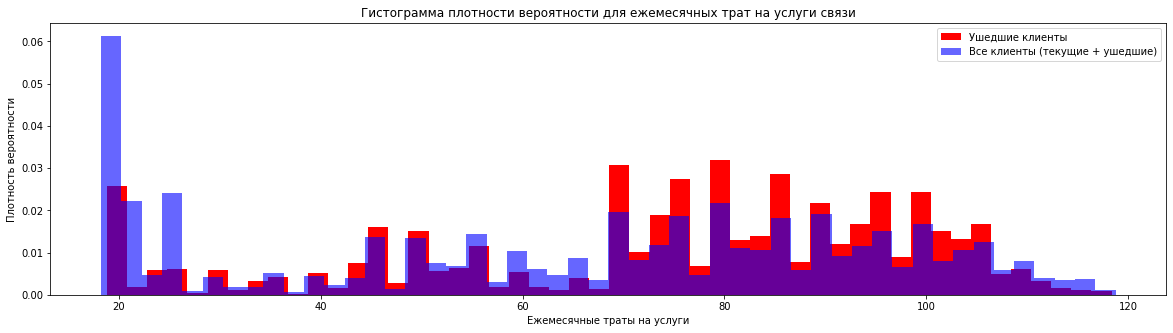

In [46]:
    _, ax = plt.subplots(figsize=(20, 5))

    ax.hist(lost['MonthlyCharges'], color = "r", alpha = 1, label = "Ушедшие клиенты", density = True, bins = 50);
    ax.hist(data_merged['MonthlyCharges'], color = "b", alpha = 0.6, label = "Все клиенты (текущие + ушедшие)", density = True, bins = 50);
    ax.set_ylabel('Плотность вероятности')
    ax.set_xlabel('Ежемесячные траты на услуги')
    ax.set_title('Гистограмма плотности вероятности для ежемесячных трат на услуги связи')
    ax.legend(loc = 'best');

Построим графики, изображающие долю пользователей телефонной связи и долю интернет-пользователей. Для этого сначала создадим вспомогательные таблички с подсчётом этих долей.

In [47]:
lost_internet = lost['InternetService'].value_counts(normalize = True).to_frame()
lost_internet

,InternetService
Fiber optic,0.694
DSL,0.246
non_user,0.060


In [48]:
data_merged_internet = data_merged['InternetService'].value_counts(normalize = True).to_frame()
data_merged_internet

,InternetService
Fiber optic,0.440
DSL,0.344
non_user,0.217


In [49]:
lost_phone = lost['MultipleLines'].value_counts(normalize = True).to_frame()
lost_phone.index = ['Использует MultipleLines', 'Не использует MultipleLines', 'non_user']
lost_phone

,MultipleLines
Использует MultipleLines,0.455
Не использует MultipleLines,0.454
non_user,0.091


In [50]:
data_merged_phone = data_merged['MultipleLines'].value_counts(normalize = True).to_frame()
data_merged_phone.index = ['Использует MultipleLines', 'Не использует MultipleLines', 'non_user']
data_merged_phone

,MultipleLines
Использует MultipleLines,0.481
Не использует MultipleLines,0.422
non_user,0.097


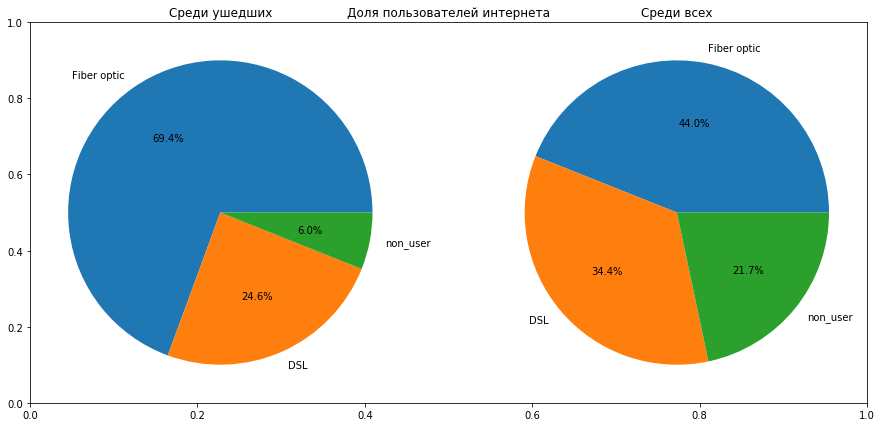

In [51]:
plt.rcParams['font.size'] = 10
fig = plt.figure(figsize=(15,7))
plt.title('Доля пользователей интернета')
ax1 = fig.add_subplot(121, title = "Среди ушедших")
ax1 = plt.pie(lost_internet['InternetService'], autopct='%.1f%%', labels = lost_internet.index);
ax2 = fig.add_subplot(122, title = "Среди всех")
ax1 = plt.pie(data_merged_internet['InternetService'], autopct='%.1f%%', labels = data_merged_internet.index);
plt.show()

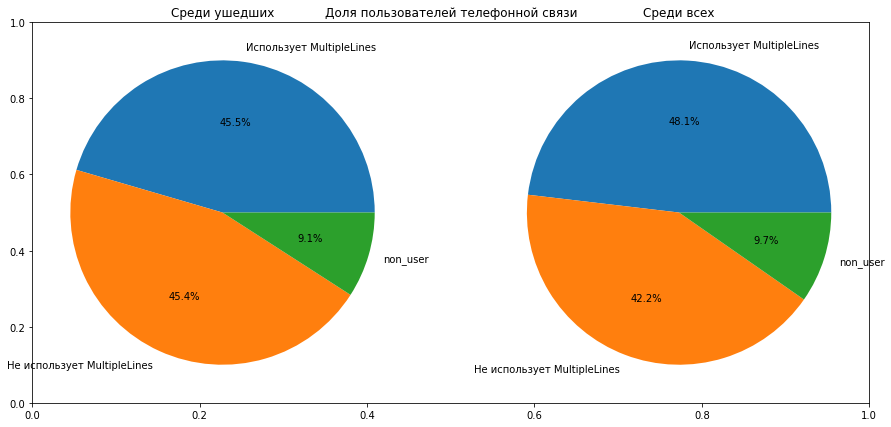

In [52]:
plt.rcParams['font.size'] = 10
fig = plt.figure(figsize=(15,7))
plt.title('Доля пользователей телефонной связи')
ax1 = fig.add_subplot(121, title = "Среди ушедших")
ax1 = plt.pie(lost_phone['MultipleLines'], autopct='%.1f%%', labels = lost_phone.index);
ax2 = fig.add_subplot(122, title = "Среди всех")
ax1 = plt.pie(data_merged_phone['MultipleLines'], autopct='%.1f%%', labels = data_merged_phone.index);
plt.show()

***Вывод***

Среди ушедших клиентов почти все (94%) являлись пользователями интернета. При этом почти 70% использовали подключение через оптоволоконный кабель (в отличие от 44% использующих это соединение по всем клиентам), что скорее всего говорит о плохом соотношении "цена/качества" данной услуги.

По телефонии доли среди ушедших клиентов почти такие же, как и среди всех.

Наблюдается диспропорция в распределении данных внутри выборок: в среднем ушедшие клиенты платили больше.

Предложения для компании "Ниединогоразрыва.ком":

- проверить качество и конкурентоспособность предоставляемых услуг (особенно интернет-услуг);
- разрабатывать маркетинговые акции для разных групп пользователей (отдельное предложение для пенсионеров и пр.)


<a id="split"></a>
## 4. Разделение данных на выборки для обучения

Разделим данные на обучающую и тестовую выборки.

In [53]:
data_train, data_test = train_test_split(data_ohe, test_size=0.25, random_state=12345)

In [54]:
features_train = data_train.drop(['target', 'customerID', 'BeginDate', 'EndDate', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'TotalCharges'], axis=1)
target_train = data_train['target']
features_test = data_test.drop(['target', 'customerID', 'BeginDate', 'EndDate', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'TotalCharges'], axis=1)
target_test = data_test['target']

In [55]:
features_train.head()

,Type,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,InternetService,MultipleLines,time_with_company,PaperlessBilling_Yes,gender_Male,Dependents_Yes
845,1.000,3.000,20.550,0,1.000,2.000,0.000,457,0,0,1
6386,2.000,1.000,83.550,0,1.000,0.000,1.000,2191,1,1,1
1194,0.000,2.000,50.450,0,0.000,0.000,0.000,427,0,0,0
5787,0.000,2.000,87.550,0,0.000,1.000,0.000,1095,1,0,0
3585,1.000,3.000,90.150,1,1.000,1.000,0.000,1036,0,1,0


In [56]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 845 to 4578
Data columns (total 11 columns):
Type                    5282 non-null float64
PaymentMethod           5282 non-null float64
MonthlyCharges          5282 non-null float64
SeniorCitizen           5282 non-null int64
Partner                 5282 non-null float64
InternetService         5282 non-null float64
MultipleLines           5282 non-null float64
time_with_company       5282 non-null int64
PaperlessBilling_Yes    5282 non-null uint8
gender_Male             5282 non-null uint8
Dependents_Yes          5282 non-null uint8
dtypes: float64(6), int64(2), uint8(3)
memory usage: 386.9 KB


Масштабируем численные переменные

In [57]:
numeric = ['MonthlyCharges', 'time_with_company']

In [58]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [59]:
display(features_test.head())

,Type,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,InternetService,MultipleLines,time_with_company,PaperlessBilling_Yes,gender_Male,Dependents_Yes
1128,0.000,2.000,-1.514,0,0.000,2.000,0.000,-0.229,1,1,0
2875,0.000,2.000,0.669,0,1.000,1.000,1.000,-0.436,1,1,0
1783,0.000,2.000,0.222,0,0.000,1.000,0.000,-1.293,1,1,1
3804,0.000,2.000,0.494,0,0.000,1.000,1.000,-0.922,0,1,0
6087,1.000,0.000,-0.831,0,0.000,0.000,2.000,-0.270,1,1,1


***Вывод***

Данные для обучения были разбиты на обучающую и тестовую выборки, численные переменные были масштабированы.

<a id="disbalance"></a>
## 5. Борьба с дисбалансом в выборке

Данные несбалансированны по целевому признаку. Попробуем применить метод downsampling для некоторых моделей.

In [60]:
data_ohe['target'].value_counts(normalize = True)

0   0.735
1   0.265
Name: target, dtype: float64

Создадим функцию downsample, которая разделяет выборку на отрицательные и положительные объекты, случайным образом отбрасывает часть объектов отрицательного класса и перемешивает данные. Затем применим её к нашим данным.

In [61]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)

In [62]:
display(target_downsampled.value_counts(normalize=True))

0   0.582
1   0.418
Name: target, dtype: float64

In [63]:
features_downsampled[numeric] = scaler.transform(features_downsampled[numeric])

***Вывод***

Данные для моделей, которые будут использовать downsampling, также подготовлены, численные переменные в них масштабированы.

<a id="modelling"></a>
## 6. Моделирование

Сначала применим модель CatBoostClassifier, используем для неё метод grid_search, обучим с найденными параметрами, по результатам обучения модели отбросим малозначимые параметры (использую метод feature_importance) и обучим модель ещё раз уже без этих параметров. Затем обучим другие модели.

<a id="cat"></a>
###  6.1. CatBoost

In [64]:
model = CatBoostClassifier()

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid, 
                                       X=features_train, 
                                       y=target_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6741207	test: 0.6746327	best: 0.6746327 (0)	total: 145ms	remaining: 2m 24s
1:	learn: 0.6564974	test: 0.6576095	best: 0.6576095 (1)	total: 152ms	remaining: 1m 16s
2:	learn: 0.6387033	test: 0.6406748	best: 0.6406748 (2)	total: 159ms	remaining: 52.8s
3:	learn: 0.6250699	test: 0.6274492	best: 0.6274492 (3)	total: 170ms	remaining: 42.3s
4:	learn: 0.6113936	test: 0.6143489	best: 0.6143489 (4)	total: 179ms	remaining: 35.6s
5:	learn: 0.5984790	test: 0.6020078	best: 0.6020078 (5)	total: 186ms	remaining: 30.7s
6:	learn: 0.5862018	test: 0.5900331	best: 0.5900331 (6)	total: 195ms	remaining: 27.6s
7:	learn: 0.5749504	test: 0.5791276	best: 0.5791276 (7)	total: 199ms	remaining: 24.7s
8:	learn: 0.5651685	test: 0.5697197	best: 0.5697197 (8)	total: 203ms	remaining: 22.4s
9:	learn: 0.5535972	test: 0.5586645	best: 0.5586645 (9)	total: 210ms	remaining: 20.8s
10:	learn: 0.5449408	test: 0.5503346	best: 0.5503346 (10)	total: 213ms	remaining: 19.1s
11:	learn: 0.5350101	test: 0.5406744	best: 0.54067

In [65]:
model_cat = CatBoostClassifier(loss_function="Logloss", random_seed=12345, iterations=500, learning_rate = 0.1, depth = 4, l2_leaf_reg = 1)

In [66]:
model_cat.fit(features_train, target_train, verbose=10)

0:	learn: 0.6421263	total: 6.66ms	remaining: 3.32s
10:	learn: 0.4334306	total: 53.7ms	remaining: 2.39s
20:	learn: 0.3969124	total: 98.8ms	remaining: 2.25s
30:	learn: 0.3828160	total: 141ms	remaining: 2.14s
40:	learn: 0.3703913	total: 185ms	remaining: 2.07s
50:	learn: 0.3643025	total: 230ms	remaining: 2.02s
60:	learn: 0.3597998	total: 277ms	remaining: 1.99s
70:	learn: 0.3552177	total: 331ms	remaining: 2s
80:	learn: 0.3504992	total: 383ms	remaining: 1.98s
90:	learn: 0.3444489	total: 438ms	remaining: 1.97s
100:	learn: 0.3378707	total: 488ms	remaining: 1.93s
110:	learn: 0.3304975	total: 539ms	remaining: 1.89s
120:	learn: 0.3229776	total: 591ms	remaining: 1.85s
130:	learn: 0.3174783	total: 642ms	remaining: 1.81s
140:	learn: 0.3141519	total: 696ms	remaining: 1.77s
150:	learn: 0.3074172	total: 747ms	remaining: 1.73s
160:	learn: 0.3028336	total: 799ms	remaining: 1.68s
170:	learn: 0.2978603	total: 864ms	remaining: 1.66s
180:	learn: 0.2935727	total: 948ms	remaining: 1.67s
190:	learn: 0.2885822	t

In [67]:
predicted_test = model_cat.predict(features_test)

In [68]:
probabilities_test = model_cat.predict_proba(features_test)

In [69]:
probabilities_one_test = probabilities_test[:, 1]

In [70]:
roc_auc_cat_base = roc_auc_score(target_test, probabilities_one_test)

In [71]:
print("AUC-ROC на тестовой выборке:", roc_auc_cat_base)

AUC-ROC на тестовой выборке: 0.9302945062438732


In [72]:
accuracy_cat = accuracy_score(target_test, predicted_test)
print("Accuracy модели catboost", accuracy_cat)

Accuracy модели catboost 0.8886996024985804


In [73]:
features_train.head()

,Type,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,InternetService,MultipleLines,time_with_company,PaperlessBilling_Yes,gender_Male,Dependents_Yes
845,1.000,3.000,-1.476,0,1.000,2.000,0.000,-0.720,0,0,1
6386,2.000,1.000,0.617,0,1.000,0.000,1.000,1.609,1,1,1
1194,0.000,2.000,-0.483,0,0.000,0.000,0.000,-0.760,0,0,0
5787,0.000,2.000,0.750,0,0.000,1.000,0.000,0.137,1,0,0
3585,1.000,3.000,0.836,1,1.000,1.000,0.000,0.058,0,1,0


In [74]:
print(model_cat.feature_importances_)

[ 6.92772012  3.55475892 10.46488496  0.8312516   0.55304077  4.94387936
  1.74982335 68.33151874  1.11948658  0.52878176  0.99485384]


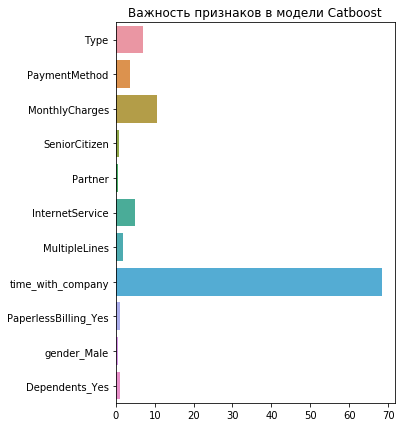

In [75]:
plt.figure(figsize = (5, 7) )
sns.barplot(y=features_train.columns, x = model_cat.feature_importances_, orient='h')
plt.title('Важность признаков в модели Catboost');

<a id="cat_short"></a>
### 6.2. Модель Catboost после удаления неважных признаков

In [76]:
features_train.head()

,Type,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,InternetService,MultipleLines,time_with_company,PaperlessBilling_Yes,gender_Male,Dependents_Yes
845,1.000,3.000,-1.476,0,1.000,2.000,0.000,-0.720,0,0,1
6386,2.000,1.000,0.617,0,1.000,0.000,1.000,1.609,1,1,1
1194,0.000,2.000,-0.483,0,0.000,0.000,0.000,-0.760,0,0,0
5787,0.000,2.000,0.750,0,0.000,1.000,0.000,0.137,1,0,0
3585,1.000,3.000,0.836,1,1.000,1.000,0.000,0.058,0,1,0


Удалим признаки, влияние которых оказалось низким

In [77]:
features_train_new = features_train.drop(['SeniorCitizen', 'Partner', 'gender_Male', 'Dependents_Yes'], axis=1)
features_test_new = features_test.drop(['SeniorCitizen', 'Partner', 'gender_Male', 'Dependents_Yes'], axis=1)

In [78]:
model_cat_short = CatBoostClassifier(loss_function="Logloss", random_seed=12345, iterations=500, learning_rate = 0.1, depth = 4, l2_leaf_reg = 1)

In [79]:
model_cat_short.fit(features_train_new, target_train, verbose=10)

0:	learn: 0.6264624	total: 7.04ms	remaining: 3.51s
10:	learn: 0.4311367	total: 67.8ms	remaining: 3.01s
20:	learn: 0.3960337	total: 113ms	remaining: 2.58s
30:	learn: 0.3817119	total: 156ms	remaining: 2.35s
40:	learn: 0.3749980	total: 196ms	remaining: 2.2s
50:	learn: 0.3655588	total: 238ms	remaining: 2.1s
60:	learn: 0.3625666	total: 279ms	remaining: 2.01s
70:	learn: 0.3557203	total: 355ms	remaining: 2.15s
80:	learn: 0.3509340	total: 402ms	remaining: 2.08s
90:	learn: 0.3438238	total: 445ms	remaining: 2s
100:	learn: 0.3372099	total: 491ms	remaining: 1.94s
110:	learn: 0.3314457	total: 537ms	remaining: 1.88s
120:	learn: 0.3245494	total: 581ms	remaining: 1.82s
130:	learn: 0.3170726	total: 627ms	remaining: 1.77s
140:	learn: 0.3125280	total: 672ms	remaining: 1.71s
150:	learn: 0.3065529	total: 718ms	remaining: 1.66s
160:	learn: 0.3010305	total: 769ms	remaining: 1.62s
170:	learn: 0.2960075	total: 823ms	remaining: 1.58s
180:	learn: 0.2910456	total: 869ms	remaining: 1.53s
190:	learn: 0.2868611	tota

In [80]:
predicted_test_short = model_cat_short.predict(features_test_new)
probabilities_test_short = model_cat_short.predict_proba(features_test_new)
probabilities_one_test_short = probabilities_test_short[:, 1]
auc_cat_short = roc_auc_score(target_test, probabilities_one_test_short)
print("AUC-ROC модели CatBoost без малозначимых признаков:", auc_cat_short)
accuracy_cat_short = accuracy_score(target_test, predicted_test_short)
print("Accuracy модели catboost без малозначимых признаков", accuracy_cat_short)

AUC-ROC модели CatBoost без малозначимых признаков: 0.934830289260669
Accuracy модели catboost без малозначимых признаков 0.8886996024985804


<a id="logistic"></a>
### 6.3. LogisticRegression_weighted

In [81]:
features_train.head()

,Type,PaymentMethod,MonthlyCharges,SeniorCitizen,Partner,InternetService,MultipleLines,time_with_company,PaperlessBilling_Yes,gender_Male,Dependents_Yes
845,1.000,3.000,-1.476,0,1.000,2.000,0.000,-0.720,0,0,1
6386,2.000,1.000,0.617,0,1.000,0.000,1.000,1.609,1,1,1
1194,0.000,2.000,-0.483,0,0.000,0.000,0.000,-0.760,0,0,0
5787,0.000,2.000,0.750,0,0.000,1.000,0.000,0.137,1,0,0
3585,1.000,3.000,0.836,1,1.000,1.000,0.000,0.058,0,1,0


In [82]:
target_train.value_counts()

0    3887
1    1395
Name: target, dtype: int64

In [83]:
parameters = {'C': np.linspace(0.0001, 100, 20)}
grid_search = GridSearchCV(LogisticRegression(), parameters)
grid_search.fit(features_train, target_train)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 5.263252631578947}
best scrores:  0.7991318697858434


In [84]:
model_logist = LogisticRegression(C=36.842168421052634, random_state=12345, class_weight='balanced')

model_logist.fit(features_train, target_train)

LogisticRegression(C=36.842168421052634, class_weight='balanced',
                   random_state=12345)

In [85]:
predictions_test_logist = model_logist.predict(features_test)
probabilities_test_logist = model_logist.predict_proba(features_test)
probabilities_one_test_logist = probabilities_test_logist[:, 1]
auc_logist= roc_auc_score(target_test, probabilities_one_test_logist)
print("AUC-ROC модели сбалансированной логистической регрессии:", auc_logist)
accuracy_logist = accuracy_score(target_test, predictions_test_logist)
print("Accuracy модели сбалансированной логистической регрессии", accuracy_logist)

AUC-ROC модели сбалансированной логистической регрессии: 0.8353430442038038
Accuracy модели сбалансированной логистической регрессии 0.7228847245883021


<a id="lgbm"></a>
### 6.4. Модель LGBMClassifier (без малозначимых признаков)

In [86]:
model_light = LGBMClassifier(random_state=12345, n_estimators=100)

In [87]:
model_light.fit(features_train_new, target_train, verbose=10)

LGBMClassifier(random_state=12345)

In [88]:
predicted_test_light = model_light.predict(features_test_new)
probabilities_test_light = model_light.predict_proba(features_test_new)
probabilities_one_test_light = probabilities_test_light[:, 1]
auc_light = roc_auc_score(target_test, probabilities_one_test_light)
print("AUC-ROC модели LGBMClassifier:", auc_light)
accuracy_light = accuracy_score(target_test, predicted_test_light)
print("Accuracy модели LGBMClassifier", accuracy_light)

AUC-ROC модели LGBMClassifier: 0.9097548021598655
Accuracy модели LGBMClassifier 0.8625780806360023


<a id="cat_down"></a>
### 6.5. Catboost на уменьшенной выборке

In [89]:
model_cat_down = CatBoostClassifier(loss_function="Logloss", random_seed=12345, iterations=150)

In [90]:
model_cat_down.fit(features_downsampled, target_downsampled, verbose=10)

Learning rate set to 0.098184
0:	learn: 0.6644779	total: 3.47ms	remaining: 518ms
10:	learn: 0.5259515	total: 37.7ms	remaining: 476ms
20:	learn: 0.4818460	total: 71.8ms	remaining: 441ms
30:	learn: 0.4598205	total: 104ms	remaining: 401ms
40:	learn: 0.4480711	total: 146ms	remaining: 389ms
50:	learn: 0.4402099	total: 183ms	remaining: 356ms
60:	learn: 0.4341011	total: 223ms	remaining: 325ms
70:	learn: 0.4283837	total: 257ms	remaining: 286ms
80:	learn: 0.4224526	total: 293ms	remaining: 249ms
90:	learn: 0.4173079	total: 328ms	remaining: 213ms
100:	learn: 0.4110790	total: 364ms	remaining: 177ms
110:	learn: 0.4054694	total: 404ms	remaining: 142ms
120:	learn: 0.3995601	total: 446ms	remaining: 107ms
130:	learn: 0.3952741	total: 483ms	remaining: 70ms
140:	learn: 0.3915377	total: 523ms	remaining: 33.4ms
149:	learn: 0.3878851	total: 560ms	remaining: 0us


In [91]:
predicted_test_down = model_cat_down.predict(features_test)
probabilities_test_down = model_cat_down.predict_proba(features_test)
probabilities_one_test_down = probabilities_test_down[:, 1]
auc_cat_down = roc_auc_score(target_test, probabilities_one_test_down)
print("AUC-ROC модели CatBoost на уменьшенной выборке:", auc_cat_down)
accuracy_cat_down = accuracy_score(target_test, predicted_test_down)
print("Accuracy модели catboost на уменьшенной выборке", accuracy_cat_down)

AUC-ROC модели CatBoost на уменьшенной выборке: 0.7928317580216314
Accuracy модели catboost на уменьшенной выборке 0.7308347529812607


<a id="summary"></a>
## Общий вывод

Выведем итоговую таблицу с результатами предсказания на тестовой выборке для рассмотренных моделей.

In [92]:
summary = pd.DataFrame({'model': ['CatBoost', 'CatBoost без малозначимых признаков', 'LogisticRegression_weighted', 'LGBMClassifier без малозначимых признаков', 'Catboost на уменьшенной выборке'],
                        'ROC-AUC': [roc_auc_cat_base, auc_cat_short, auc_logist, auc_light, auc_cat_down],
                       'Accuracy': [accuracy_cat, accuracy_cat_short, accuracy_logist, accuracy_light, accuracy_cat_down],})
summary

,model,ROC-AUC,Accuracy
0,CatBoost,0.930,0.889
1,CatBoost без малозначимых признаков,0.935,0.889
2,LogisticRegression_weighted,0.835,0.723
3,LGBMClassifier без малозначимых признаков,0.910,0.863
4,Catboost на уменьшенной выборке,0.793,0.731


В ходе данной работы были построены модели для прогнозирования оттока клиентов для телекоммуникационной компании.
Были испробованы разные модели: CatBoost, LightGBM, LogisticRegression с разными подходами (взвешивания, уменьшения выборки для борьбы с дисбалансом классов).

Для наиболее успешных моделей был использован метод GridSearch, а также отброшены малозначимые факторы методом feature_importance.

Лидером по всем метрикам оказалась модель CatBoost, обученная с лучшими значениями гиперпараметров, с удалёнными малозначимыми признаками.

Также в ходе анализа данных выяснилось, что:

- Среди ушедших клиентов почти все (94%) являлись пользователями интернета. При этом почти 70% использовали подключение через оптоволоконный кабель (в отличие от 44% использующих это соединение по всем клиентам), что скорее всего говорит о плохом соотношении "цена/качества" данной услуги.

- Наблюдается диспропорция в распределении данных внутри выборок: в среднем ушедшие клиенты платили больше.

Предложения для компании:

- проверить качество и конкурентоспособность предоставляемых услуг (особенно интернет-услуг);

- разрабатывать маркетинговые акции для разных групп пользователей (отдельное предложение для пенсионеров и пр.)